In [1]:
# ! pip install --upgrade pip
# ! pip install --upgrade git+https://github.com/oda-hub/oda_api@request-list pandas
# ! pip install linked-data-latex
# ! pip install ruamel.yaml
# ! pip install pymosaic-fits


import oda_api.api
import oda_api.token
import oda_api.plot_tools
import requests
import logging
from matplotlib import pylab as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
import pandas as pd
import numpy as np
from ddpaper.draftdata import DraftData
import io

# https://gcn.gsfc.nasa.gov/gcn3/32634.gcn3

In [2]:
# oda:version "dev1.1.30"

In [3]:
#TODO: statistics on odaf failures at the and of compute

In [4]:
# #slightly more verbose
logging.getLogger().setLevel(logging.INFO)
# #all messages
#logging.getLogger().setLevel(logging.DEBUG)

logging.getLogger('oda_api').addHandler(logging.StreamHandler())

In [5]:
# 120711 https://www.aanda.org/articles/aa/pdf/2014/07/aa20872-12.pdf
# https://www.cosmos.esa.int/web/integral/schedule-information

In [6]:
from matplotlib import pylab as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time
import pandas as pd
import numpy as np

In [7]:
T0_isot = "2022-10-09T13:17:00"
T0_ijd = Time(T0_isot, scale='utc').tt.mjd - 51544

src_coord = SkyCoord("19h 13m 03.43s", "+19d 46m 23.1s", unit=u.deg)
source_name = "GRB221009A"
src_coord

<SkyCoord (ICRS): (ra, dec) in deg
    (288.26429167, 19.77308333)>

In [8]:
float(Time(51544, format='mjd', scale='ut1').mjd) - Time(51544, format='mjd', scale='tai').mjd

0.0

In [9]:
with DraftData() as dd:
    dd['sc'] = requests.get(f"https://www.astro.unige.ch/mmoda/dispatch-data/gw/scsystem/api/v1.0/sc/{T0_isot}/{src_coord.ra.deg}/{src_coord.dec.deg}").json()
    dd['sc_second_pointing'] = requests.get(f"https://www.astro.unige.ch/mmoda/dispatch-data/gw/scsystem/api/v1.0/sc/{Time(Time(T0_isot).mjd + 700./24/3600, format='mjd').isot}/{src_coord.ra.deg}/{src_coord.dec.deg}").json()

dd['sc']['theta'],dd['sc_second_pointing']['theta']

/home/savchenk/.local/lib/python3.10/site-packages/ddpaper/draftdata.py:20: UnsafeLoaderWarning: 
The default 'Loader' for 'load(stream)' without further arguments can be unsafe.
Use 'load(stream, Loader=ruamel.yaml.Loader)' explicitly if that is OK.
Alternatively include the following in your code:

  import warnings
  warnings.simplefilter('ignore', ruamel.yaml.error.UnsafeLoaderWarning)

In most other cases you should consider using 'safe_load(stream)'
  self.data = yaml.load(


(65.81131216259752, 67.68686829882438)

In [10]:
acslc_r = requests.get(f"https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//integralhk/api/v1.0/genlc/ACS/{T0_ijd}/2000")
import pandas as pd
import io

acslc = pd.read_csv(io.StringIO(acslc_r.text), skiprows=5, names=['t', 'dt', 'c', 'ds'], delim_whitespace=True)
acslc

,t,dt,c,ds
0,8317.531125,0.001364,5264.0,45820.001364
1,8317.531125,0.051363,5102.0,45820.051363
2,8317.531126,0.101364,5234.0,45820.101364
3,8317.531127,0.151363,5374.0,45820.151363
4,8317.531127,0.201365,5244.0,45820.201364
...,...,...,...,...
79995,8317.577418,3999.754042,5322.0,49819.754042
79996,8317.577419,3999.804041,5130.0,49819.804041
79997,8317.577419,3999.854042,5376.0,49819.854042
79998,8317.577420,3999.904042,5426.0,49819.904041


In [11]:
acs_saturation_t = acslc.t[acslc.c > 90000]

acs_saturation = {
    't1': {'ijd': acs_saturation_t.min(), 't_rel_s': (acs_saturation_t.min() - T0_ijd)*24*3600},
    't2': {'ijd': acs_saturation_t.max(), 't_rel_s': (acs_saturation_t.max() - T0_ijd)*24*3600}
}

acs_saturation

{'t1': {'ijd': 8317.55682507935, 't_rel_s': 220.50285607692786},
 't2': {'ijd': 8317.557361538058, 't_rel_s': 266.85288850567304}}

In [12]:
src_coord = SkyCoord("19h 13m 03.43s", "+19d 46m 23.1s", unit=u.deg)
source_name = "GRB221009A"
src_coord

<SkyCoord (ICRS): (ra, dec) in deg
    (288.26429167, 19.77308333)>

In [13]:
import subprocess
import io
import pathlib
from astropy.io import fits

def sshopen(fn):
    cfn = pathlib.Path("/tmp/sshopen-cache/") / fn.replace("/", "_")
    cfn.parent.mkdir(exist_ok=True)

    try:
        of = fits.open(cfn)
    except:
        f = io.BytesIO(subprocess.check_output(f"ssh login01.astro.unige.ch tar cf - {fn} | tar xf - -O", shell=True))

        with open(cfn, "wb") as F:
            F.write(f.read())
        
        of = fits.open(cfn)
    return of

sshopen("/isdc/arc/rev_3/scw/2558/255800290010.001/compton_events.fits.gz")


[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7fac86347760>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fac86347bb0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fac864f3670>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fac864f1ea0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fac864f34f0>]

In [14]:
sshopen("/isdc/arc/rev_3/scw/2558/255800290010.001/compton_events.fits.gz")

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7fac864f2ec0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fac86346bc0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fac86346320>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fac86347eb0>, <astropy.io.fits.hdu.table.BinTableHDU object at 0x7fac85af8280>]

In [15]:
hklc = {}

In [16]:

def gethklc(n):
    r = requests.get(f"https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//integralhk/api/v1.0/genlc/{n}/{T0_ijd}/4000")
    return pd.read_csv(io.StringIO(r.text), skiprows=5, names=['t', 'dt', 'c', 'ds'], delim_whitespace=True)

# IBIS_VETO
for n in ['SPI_VETOGATE', 'SPI_VETONONSAT', 'SPI_VETOSAT'] + \
         [f'SPI_GEDRATE{i}' for i in range(19)] + \
         [f'SPI_GEDSAT{i}' for i in range(19)]:
        #   'FEE{i}' for i in range(1, 92)]:
    print("fetching", n)

    if n not in hklc:
        hklc[n] = gethklc(n)
    
    

fetching SPI_VETOGATE
fetching SPI_VETONONSAT
fetching SPI_VETOSAT
fetching SPI_GEDRATE0
fetching SPI_GEDRATE1
fetching SPI_GEDRATE2
fetching SPI_GEDRATE3
fetching SPI_GEDRATE4
fetching SPI_GEDRATE5
fetching SPI_GEDRATE6
fetching SPI_GEDRATE7
fetching SPI_GEDRATE8
fetching SPI_GEDRATE9
fetching SPI_GEDRATE10
fetching SPI_GEDRATE11
fetching SPI_GEDRATE12
fetching SPI_GEDRATE13
fetching SPI_GEDRATE14
fetching SPI_GEDRATE15
fetching SPI_GEDRATE16
fetching SPI_GEDRATE17
fetching SPI_GEDRATE18
fetching SPI_GEDSAT0
fetching SPI_GEDSAT1
fetching SPI_GEDSAT2
fetching SPI_GEDSAT3
fetching SPI_GEDSAT4
fetching SPI_GEDSAT5
fetching SPI_GEDSAT6
fetching SPI_GEDSAT7
fetching SPI_GEDSAT8
fetching SPI_GEDSAT9
fetching SPI_GEDSAT10
fetching SPI_GEDSAT11
fetching SPI_GEDSAT12
fetching SPI_GEDSAT13
fetching SPI_GEDSAT14
fetching SPI_GEDSAT15
fetching SPI_GEDSAT16
fetching SPI_GEDSAT17
fetching SPI_GEDSAT18


In [17]:
for p in 'SPI_GEDSAT', 'SPI_GEDRATE':

    if p in hklc:
        hklc.__delitem__(p) # = None

    for k, v in list(hklc.items()):
        if len(v.t) < 10: continue
        if k.startswith(p) and k!=p:
            if p not in hklc:
                hklc[p] = v.copy(deep=True)
                print("new")
            else:
                print("adding", k, v.c.mean())
                hklc[p].c = np.array(hklc[p].c).copy() + np.array(v.c).copy() 

            if p in hklc:    
                print(hklc[p].c.mean())

new
264.547875
adding SPI_GEDSAT3 268.05325
532.601125
adding SPI_GEDSAT4 269.027875
801.629
adding SPI_GEDSAT6 269.82975
1071.45875
adding SPI_GEDSAT7 268.325125
1339.783875
adding SPI_GEDSAT8 273.515375
1613.29925
adding SPI_GEDSAT9 270.658875
1883.958125
adding SPI_GEDSAT10 274.1995
2158.157625
adding SPI_GEDSAT11 272.245375
2430.403
adding SPI_GEDSAT12 265.418625
2695.821625
adding SPI_GEDSAT13 266.2955
2962.117125
adding SPI_GEDSAT14 273.288625
3235.40575
adding SPI_GEDSAT15 271.909625
3507.315375
adding SPI_GEDSAT16 272.605
3779.920375
adding SPI_GEDSAT18 275.232125
4055.1525
new
1378.504625
adding SPI_GEDRATE3 1371.39575
2749.900375
adding SPI_GEDRATE4 1378.346875
4128.24725
adding SPI_GEDRATE5 281.214875
4409.462125
adding SPI_GEDRATE6 1372.4335
5781.895625
adding SPI_GEDRATE7 1307.51825
7089.413875
adding SPI_GEDRATE8 1302.22475
8391.638625
adding SPI_GEDRATE9 1326.951
9718.589625
adding SPI_GEDRATE10 1304.06375
11022.653375
adding SPI_GEDRATE11 1319.887875
12342.54125
adding 

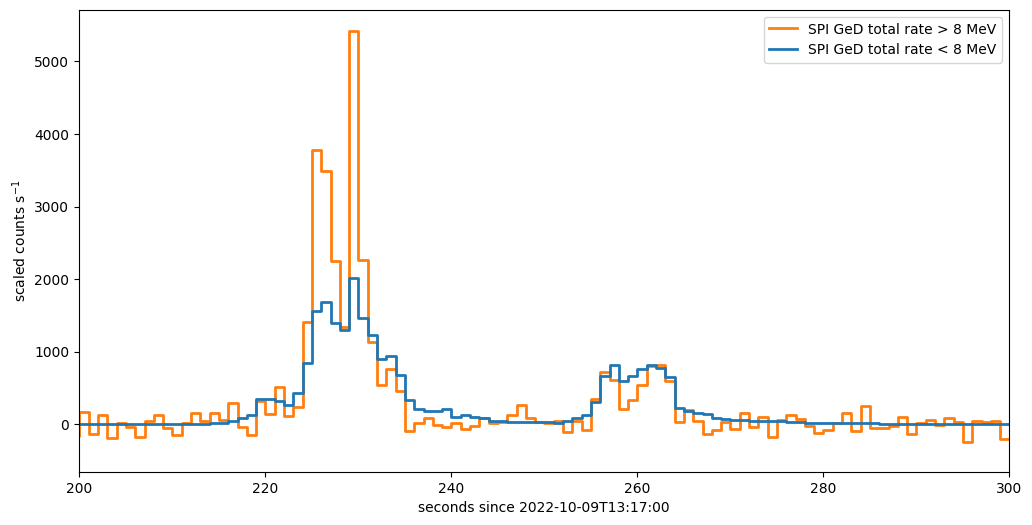

In [18]:
import re

colors = ['#1f77b4', '#ff7f0e']

def plot_spirates(ax=None):
    N = None

    groups = [
        # [
        #     'VETOSAT', 
        #     'SPI_VETOGATE', 
        #     'SPI_VETONONSAT'
        # ],
        [
            # 'GEDRATE$',
            # 'GEDSAT$',
            # 'GEDRATE$',
            # 'GEDSAT7',
            # 'GEDSAT18',
            # 'GEDRATE18',
            'GEDSAT$',
            'GEDRATE$',
            # 'GEDSAT1',
            # 'GEDRATE1',
        ],
        # ['GEDSAT0']    
    ]

    if ax is None:
        f, axes = plt.subplots(len(groups), 1, figsize=(12, 6), sharex=True)

        if len(groups) == 1:
            axes = [axes]
    else:
        axes = [ax]


    for ax, group in zip(axes, groups):
        for k in group:            
            for l, lc in hklc.items():
                if re.search(k, l):
                    if len(lc.t) < 10: continue

                    t_rel_s = (lc.t - T0_ijd)*24*3600
                    m_bkg = t_rel_s < 200
                    bkg = np.nanmean(lc.c[m_bkg])
                    s_bkg = np.nanstd(lc.c[m_bkg])
                    ev_bkg = s_bkg/bkg**0.5
                    mx = (np.nanmax(lc.c) - bkg)
                    sn = (np.nanmax(lc.c) - bkg) / s_bkg

                    if sn < 20: continue
            
                    m_n = t_rel_s > 250
                    m_n &= t_rel_s < 280
                    
                    n = np.nanmax((lc.c - bkg)[m_n])
                    if N is None:
                        N = n
                        n = 1
                        label = l
                    else:
                        n /= N
                        label = f"{l} x {int(n**-1)}"
                        
                    label += f" (EV: {ev_bkg:.2f} SD: {s_bkg:.2f} S/N {sn:.2f}) MX: {mx:.2f}" 

                    if 'GEDRATE' in label:
                        label = "SPI GeD total rate < 8 MeV"
                    else:
                        label = "SPI GeD total rate > 8 MeV"

                    # bkg =0

                    # colors.append(
                    ax.step(
                        t_rel_s,
                        (lc.c - bkg)/n,
                        # lc.c**0.5,
                        # xerr=1 + np.array(lc.t)*0,
                        lw=2,
                        # ls="",
                        label=label,
                        c=colors.pop()
                    )
                    #[0].get_color())

    # break

plt.figure(figsize=(12, 6))

plot_spirates(plt.gca())

plt.legend()
# for ax in axes:
#     ax.legend()

# plt.sca(axes[-1])

# plt.subplots_adjust(hspace=0)


plt.xlim([200, 300])
# plt.xlim([0, 600])
plt.xlabel(f"seconds since {T0_isot}")
plt.ylabel("scaled counts s$^{-1}$")
# axes[0].set_title("bottom: background-subtracted")
# plt.savefig("many_hk_rates.pdf")
plt.savefig("spi_rates.pdf")

#TODO: noise by sat

In [19]:
colors

[]

In [20]:
ijd2plot = lambda T: (T - T0_ijd)*24*3600
ijd2plot_d = lambda T: (T - T0_ijd)

In [21]:
T0_pointing_coord = dd['sc']['scx']
T0_pointing_coord

{'dec': -41.012, 'ra': 261.096}

In [22]:
mce = dict()

for i in range(8):
    mce[i] = pd.read_csv(
        io.StringIO(requests.get(f"https://www.astro.unige.ch/mmoda/dispatch-data/gw/integralhk/api/v1.0/genlc/ISGRIRAW_MCE{i}/{T0_ijd}/2000").text), 
        skiprows=5, names=['t', 'dt', 'c', 'ds'], delim_whitespace=True)


np.sum([mce[i].c for i in range(8)], axis=0)

array([ 9336,  9440,  9537,  9647,  9754,  9141,  9648,  9541,  9725,
        9699,  9358,  9424,  9764,  9644,  9488,  9863,  9245,  9707,
        9493,  9439,  9272,  9721,  9415,  9675,  9513,  9529,  9594,
        9595,  9685,  9676,  9536,  9475,  9712,  9637,  9698,  9512,
        9254,  9673,  9494,  9036,  9330,  9569,  9582,  9395,  9581,
        9548,  9421,  9713,  9508,  9503,  9407,  9224,  9554,  9304,
        9628,  9675,  9372,  9321,  9597,  9638,  9568,  9752,  9647,
        9439,  9573,  9051,  9421,  9577,  9672,  9526,  9739,  9564,
        9940,  9745,  9983,  9471,  9345,  9765,  9280,  9587,  9450,
        9353,  9450,  9621,  9361,  9671,  9640,  9501,  9377,  9721,
        9436,  9750,  9268,  9558,  9442,  9689,  9697,  9702,  9545,
        9362,  9237,  9692,  9286,  9279,  9410,  9556,  9734,  9758,
        9535,  9754,  9407,  9683,  9663,  9979,  9456,  9491, 10137,
        9468,  9560,  9520,  9511,  9332,  9185,  9599,  9489,  9619,
        9482,  9545,

In [23]:
scw_dict_prompt = pd.DataFrame(requests.get(f"https://www.astro.unige.ch/mmoda/dispatch-data/gw/timesystem/api/v1.0/scwlist/cons/{T0_ijd-500/24/3600}/{T0_ijd+2000/24/3600}?"
             f"ra={src_coord.ra.deg}&dec={src_coord.dec.deg}&radius=200&return_columns=SWID,SW_TYPE,TELAPSE,TSTART,TSTOP").json())


In [24]:
# https://heasarc.gsfc.nasa.gov/docs/integral/ao19-docs-b/AO19_recommended_programme.pdf

In [25]:
# expected isgri raw rate

isgri_pixel_eff_area = u.cm**2 * 0.4*0.4 * 1 # opacity 1 approximate
isgri_mdu_eff_area = 64 * 32* isgri_pixel_eff_area 
isgri_eff_area = 128*128* isgri_pixel_eff_area 

flux_neax_peak = 5e4 * 1e-10 * u.erg/u.cm**2/u.s

print("expected total ISGRI RAW rate =", ((flux_neax_peak * isgri_eff_area)/(u.keV * 200)).to(u.s**-1))
print("expected total ISGRI RAW waiting time =", ((flux_neax_peak * isgri_mdu_eff_area)/(u.keV * 200)).to(u.ms**-1))

expected total ISGRI RAW rate = 40904.353870386076 1 / s
expected total ISGRI RAW waiting time = 5.113044233798259 1 / ms


(0.0, 1000.0)

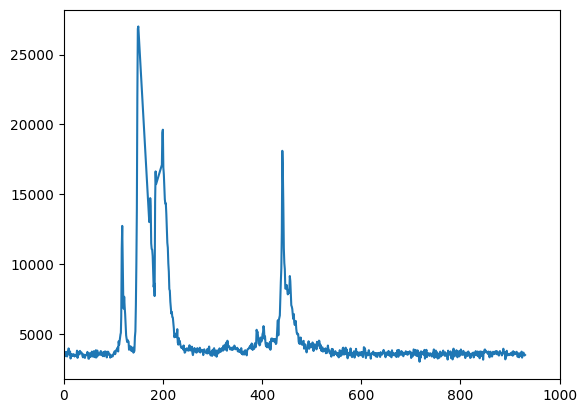

In [26]:
picsit_lc = pd.read_csv("picsit/grb221009a_afterglow_picsit_lc.txt", delim_whitespace=True, names=["mjd", "flux"])
picsit_lc_1s = pd.read_csv("picsit/grb221009a_picsit_lc_1s.txt", delim_whitespace=True, names=["mjd", "flux", "flux_err"])
picist_hr = pd.read_csv("picsit/grb221009a_afterglow_picsit_hr.txt", delim_whitespace=True, names=["mjd", "hr"])

# plt.plot(
#     (picist_hr.mjd - (T0_ijd + 51544))*24, 
#     picist_hr.hr, 
# )

t_since_t0 = np.array(picsit_lc_1s.mjd) - (T0_ijd + 51544)

plt.errorbar(
    t_since_t0*24*3600, 
    picsit_lc_1s.flux
    # (t_since_t0[1:] - t_since_t0[:-1])*24*3600, 
)
plt.xlim([0, 1000])
# plt.ylim([0, 100])

# plt.title('difference between subsequent PICsIT bins in "grb221009a_afterglow_picsit_lc.txt"')
# plt.ylabel('seconds')


# plt.loglog()

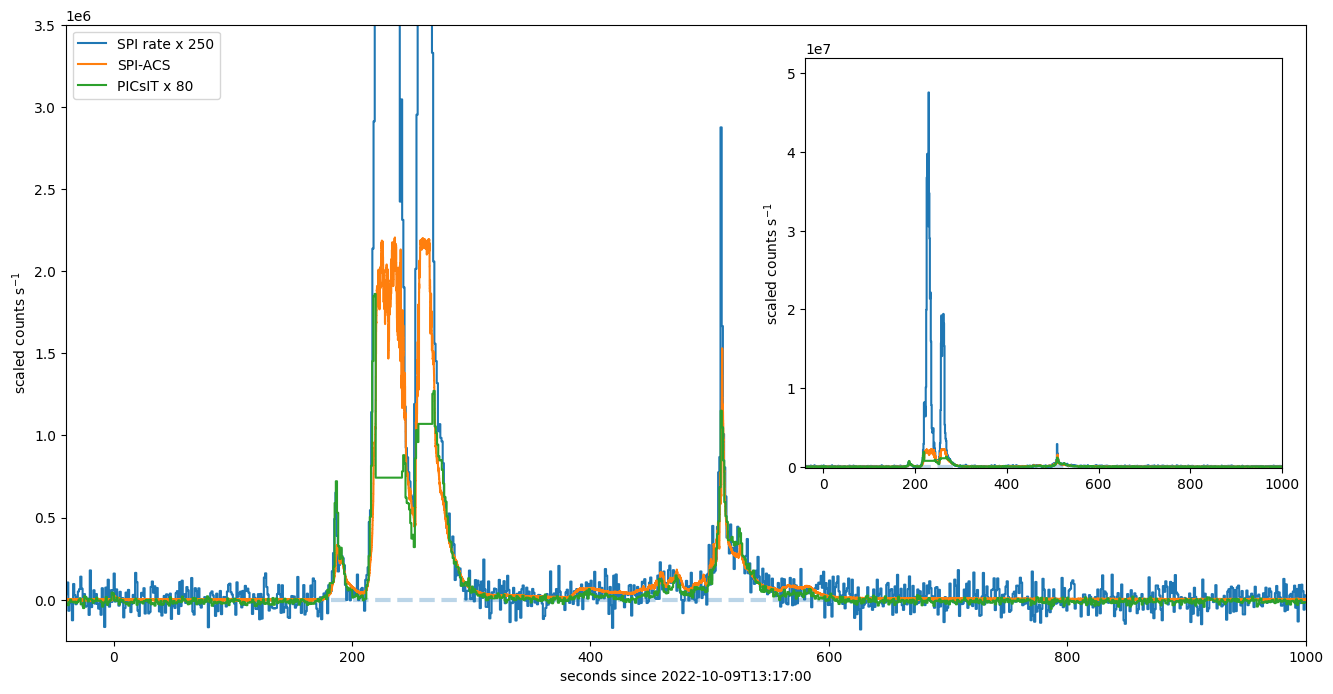

In [28]:
plt.figure(figsize=(16, 8))

from collections import defaultdict

hs_by_et = defaultdict(list)
cs_by_et = defaultdict(list)

compton_event_file = {}
isgri_event_file = {}

events_by_ext = {}

def plot_all(ax):
    
    ax.axhline(0, lw=3, ls="--", alpha=0.3)
    
    ijd2plot = lambda T: (T - T0_ijd)*24*3600

    for i, r in scw_dict_prompt.iterrows():
        scwid = r.SWID

        compton_event_file[scwid]  = sshopen(f"/isdc/arc/rev_3/scw/{scwid[:4]}/{scwid}.001/compton_events.fits.gz")
        isgri_event_file[scwid]  = sshopen(f"/isdc/arc/rev_3/scw/{scwid[:4]}/{scwid}.001/isgri_events.fits.gz")    
        # compton_event_file[scwid]  = sshopen(f"/isdc/pvphase/nrt/ops/scw/{scwid[:4]}/{scwid}.000/compton_events.fits.gz")
        # isgri_event_file[scwid]  = sshopen(f"/isdc/pvphase/nrt/ops/scw/{scwid[:4]}/{scwid}.000/isgri_events.fits.gz")    


        for C, color, ext in [
                        # (isgri_event_file, 'y', "ISGR-EVTS-ALL"),
                        # (compton_event_file, 'g', "COMP-MULE-ALL"),
                        # (compton_event_file, 'r', 'COMP-SGLE-ALL')
                    ]:
            data = C[scwid][ext].data

            label=ext + " " + scwid
        



            if ijd2plot(r.TSTART) > -100:
                ax.axvline(
                    ijd2plot(r.TSTART), ls="--", c='k', alpha=0.5
                )
                # ax.axvline(
                #     ijd2plot(r.TSTOP), ls="--", c='k', alpha=0.5
                # )

                # plt.text(ijd2plot(r.TSTART), 10000, f"{scwid[6:8]}\n{scwid[10:12]}")
                # plt.text(ijd2plot(r.TSTART), 4000, scwid, rotation=90)


            # plt.axvspan(
            #     ijd2plot(r.TSTART),
            #     ijd2plot(r.TSTOP),
            #     alpha=0.2,
            #     color='red'
            # )

            if ext in events_by_ext:
                print("adding to", ext, len(data))
                events_by_ext[ext] = np.concatenate([events_by_ext[ext], data])
            else:
                print("first to", ext, len(data))
                events_by_ext[ext] = data

            
            label = None


    F = 250
    b = np.nanmean(hklc['SPI_GEDRATE'].c[(hklc['SPI_GEDRATE'].t - T0_ijd)*24*3600 < 200])
    c = ax.step(
        ijd2plot(hklc['SPI_GEDRATE'].t), 
        (hklc['SPI_GEDRATE'].c - b)*F, 
        # picsit_lc_1s.flux / 0.8e-9, 
        label=rf"SPI rate x {F}"
    )[0].get_color()


    for ext, data in events_by_ext.items():
        T = data['TIME']

        Ei = 0
        Ep = 0

        try:
            Ei = data['ISGRI_ENERGY']            
        except:
            pass
        
        try:
            Ep = data['PICSIT_ENERGY']
        except:
            pass

        Ec = Ei + Ep

        tbin = 0.3

        h = np.histogram(ijd2plot(T), bins=np.linspace(-10, 800, int(810/tbin)))
        dt = (h[1][1:] - h[1][:-1])
        tc = (h[1][1:] + h[1][:-1]) / 2.
        rate = h[0] / dt

        
        scale = {"ISGR-EVTS-ALL": 30,
                "COMP-MULE-ALL": 4000,
                'COMP-SGLE-ALL': 600 }[ext]
        
        b = np.mean(rate[(tc < 150) & (tc > 50) & (rate>0)])

        print("bkg for", ext, "=", b)

        N = np.sum(((rate - b)*dt)[(rate - b>0) & (tc > 100) & (tc <700)])
        
        # ax.step(tc, (rate - b)*scale, alpha=0.8, label=f"{ext} x {scale:d}. {N:.0f} events")
        ax.step(tc, (rate - b)*scale, alpha=0.8, label=f"{ext} x {scale:d}")
        
    ijd2plot = lambda t:(t- T0_ijd)*24*3600

    # acs_cts2es = 1.5e-10

    b = np.mean(acslc.c[(acslc.t- T0_ijd)*24*3600 < 200])
    ax.step(ijd2plot(acslc.t), (acslc.c - b)*20, label="SPI-ACS")

    # isgri_raw_total_rate = np.sum([mce[i].c for i in range(8)], axis=0 )
    # b = np.mean(isgri_raw_total_rate[(mce[0].t- T0_ijd)*24*3600 < 200])
    # F = 10
    # ax.step((mce[0].t- T0_ijd)*24*3600, isgri_raw_total_rate - b, label=f"ISGRI RAW rate x {F}", where='post')

    # picsit

    b = np.nanmean(picsit_lc_1s.flux[(picsit_lc_1s.mjd - 51544 - T0_ijd)*24*3600 < 200])

    picsit_factor = 80
    ax.step(
        ijd2plot(picsit_lc_1s.mjd - 51544) + 69.2, 
        (picsit_lc_1s.flux - b)*picsit_factor, 
        # picsit_lc_1s.flux / 0.8e-9, 
        label=f"PICsIT x {picsit_factor}"
    )


    # plt.axhspan(-1e10, 0, color='k', alpha=0.2)
    ax.set_ylim([-1e4, 6e4])

    ax.set_xlabel(f"seconds since {T0_isot}")
    ax.set_ylabel("scaled counts s$^{-1}$")


    # F = 1000
    # b = np.nanmean(hklc['SPI_GEDSAT0'].c[(hklc['SPI_GEDSAT0'].t - T0_ijd)*24*3600 < 200])
    # c = ax.step(
    #     ijd2plot(hklc['SPI_GEDSAT0'].t), 
    #     (hklc['SPI_GEDSAT0'].c - b)*F, 
    #     # picsit_lc_1s.flux / 0.8e-9, 
    #     label=rf"SPI SAT rate x {F}"
    # )[0].get_color()

    # # plt.axhspan(-1e10, 0, color='k', alpha=0.2)
    # ax.set_ylim([-1e4, 6e4])

    # ax.set_xlabel(f"seconds since {T0_isot}")
    # ax.set_ylabel(f"counts s$^{-1}$")

plot_all(plt.gca())

# axy2 = plt.twinx()
# axy2.plot(ijd2plot(att_hist['TIME']), scx.separation(src_coord).deg)
# axy2.scatter(ijd2plot(att_hist['TIME']), scx.separation(src_coord).deg)
# axy2.set_ylim([60,75])

# plt.grid(False)

plt.legend(loc="upper left")
plt.ylim([-5e4, 6e7])
plt.xlim([150, 600])

plt.xlim([250, 400])
plt.savefig("figs/prompt_p1.pdf")

plt.xlim([-10, 10])
plt.ylim([-1e3, 1e3])
plt.savefig("figs/precursor.pdf")


bax = plt.gca()

plt.xlim([-40, 1000])

# plt.xlim([150, 600])
# plt.xlim([270, 300])

# plt.xlim([450, 600])
plt.ylim([-2.5e5, 35e5])


ax = plt.gca().inset_axes([580, 8e5, 400, 2.5e6], transform=plt.gca().transData)
# ax = plt.gca().inset_axes([350, 1e5, 600, 5e5], transform=plt.gca().transData)


plot_all(ax) #, ['compton'])
ax.set_ylim([-2e5, 5.2e7])
# ax.set_ylim([-1e5, 7e5])

# F = 50
# b = np.nanmean(hklc['SPI_GEDRATE0'].c[(hklc['SPI_GEDRATE0'].t - T0_ijd)*24*3600 < 200])
# ax.step(
#     ijd2plot(hklc['SPI_GEDRATE0'].t), 
#     (hklc['SPI_GEDRATE0'].c - b)*F, 
#     # picsit_lc_1s.flux / 0.8e-9, 
#     label=rf"SPI rate x {F}",
#     c=c
# )

ax.set_xlim(bax.get_xlim())
ax.set_xlabel(None)

plt.savefig("figs/prompt.pdf")


# ax = plt.gca().inset_axes([-80, 6e5, 220, 1.7e6], transform=plt.gca().transData)
# plot_spirates(ax)
# ax.set_xlim(bax.get_xlim())
# ax.set_xlim([200, 300])

# plt.xlim([300, 310])
# plt.ylim([-0.5e3, 3e3])


# TODO: also show early one
# TODO: search for smaller excesses allover
# TODO: check if saturation is by ISGRI module, else why smooth transitions in compton rate
# TODO: search for long-term in compton, good sensitivity
# TODO: check detector plane near compton saturations, module?

In [ ]:

for scwid in isgri_event_file.keys():
    for d, n in [(isgri_event_file[scwid][3].data, 'isgri'), (compton_event_file[scwid]['COMP-SGLE-ALL'].data, 'compton')]:
        plt.figure()

        m = d['TIME'] > T0_ijd + 150./3600./24
        m &= d['TIME'] < T0_ijd + 550/3600./24

        _ = plt.hist2d(d['ISGRI_Y'][m], d['ISGRI_Z'][m], (128, 128))
        plt.title(f"{scwid} {n}")

In [ ]:
with  pd.HDFStore("hklc.h5", "w") as store:

    for k, v in hklc.items():
        v.to_hdf(store, k)


In [ ]:
scw_dict_prompt['tstart_since_t0_s'] = ijd2plot(scw_dict_prompt.TSTART)
scw_dict_prompt['tstop_since_t0_s'] = ijd2plot(scw_dict_prompt.TSTOP)

In [ ]:
dd['sc']['bodies']['earth']['separation']

In [ ]:
hklc_h5="hklc.h5"
lc_pdf="figs/prompt.pdf"
lc_p1_pdf="figs/prompt_p1.pdf"
spi_rates_lc_pdf="spi_rates.pdf"
T0_isot=T0_isot
data=dict(dd)
scws=scw_dict_prompt.to_dict()
T0_pointing_coord=dd['sc']['scx']
sc=dd['sc']
sc_second_pointing=dd['sc_second_pointing']
acs_saturation=acs_saturation